# MVA Mini Project 1

Student: Pierre-Louis Guhur - pierre-louis.guhur@ens-paris-saclay.fr

# 1. Getting started

In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt 
%matplotlib inline
import numpy as np

from mp1 import *
from models import *

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

from keras_tqdm import TQDMCallback, TQDMNotebookCallback

models = {}

Using TensorFlow backend.


# 2. Simple Classification

Example of the classes to classify

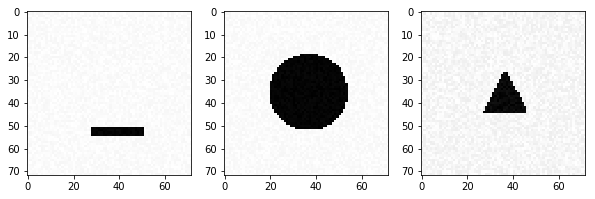

In [81]:
plt.figure(figsize=(10,10))

plt.subplot(131)
im = generate_a_rectangle(10, True)
plt.imshow(im.reshape(72,72), cmap='gray')

plt.subplot(132)
im = generate_a_disk(10)
plt.imshow(im.reshape(72,72), cmap='gray')

plt.subplot(133)
[im, v] = generate_a_triangle(20, False)
plt.imshow(im.reshape(72,72), cmap='gray')

plt.show()


In [3]:
X_train, Y_train = generate_dataset_classification(300, 20, False)
Y_train_cat = to_categorical(Y_train)
X_test, Y_test = generate_test_set_classification(300, 20, False)
Y_test_cat = to_categorical(Y_test)

Creating data: 100%|██████████| 300/300 [00:02<00:00, 100.76it/s]


## 2.1 Training a model with SGD

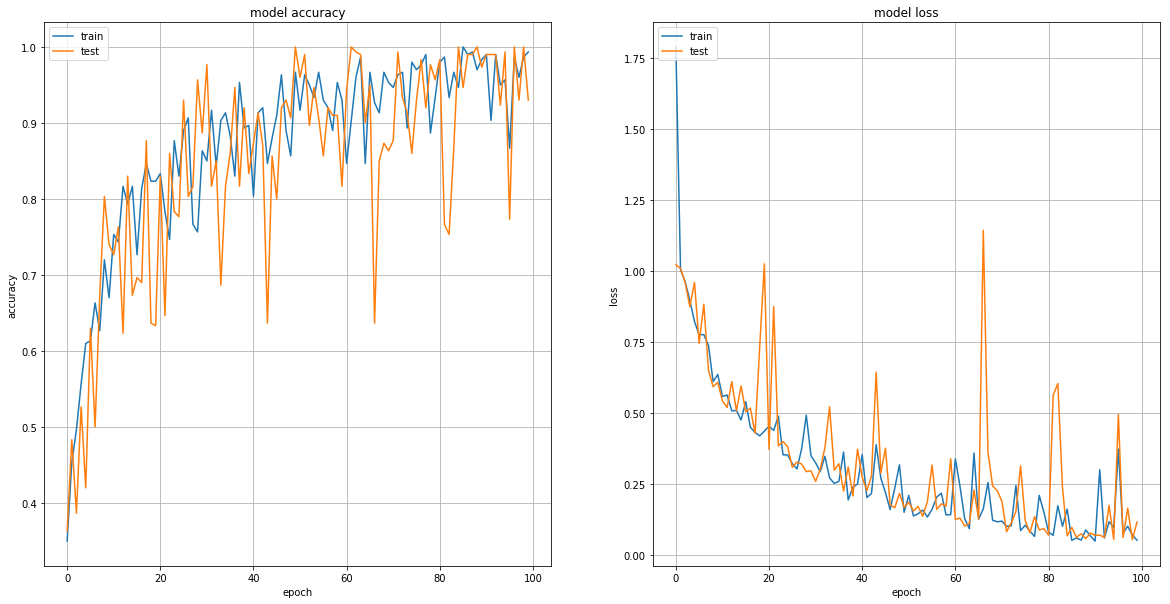

In [7]:
sgd = sgd_model()
sgd.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
history = sgd.fit(X_train, Y_train, epochs=100, validation_data=(X_test, Y_test), verbose=0)
plot_history(history)

## 2.2 Training a model with Adam

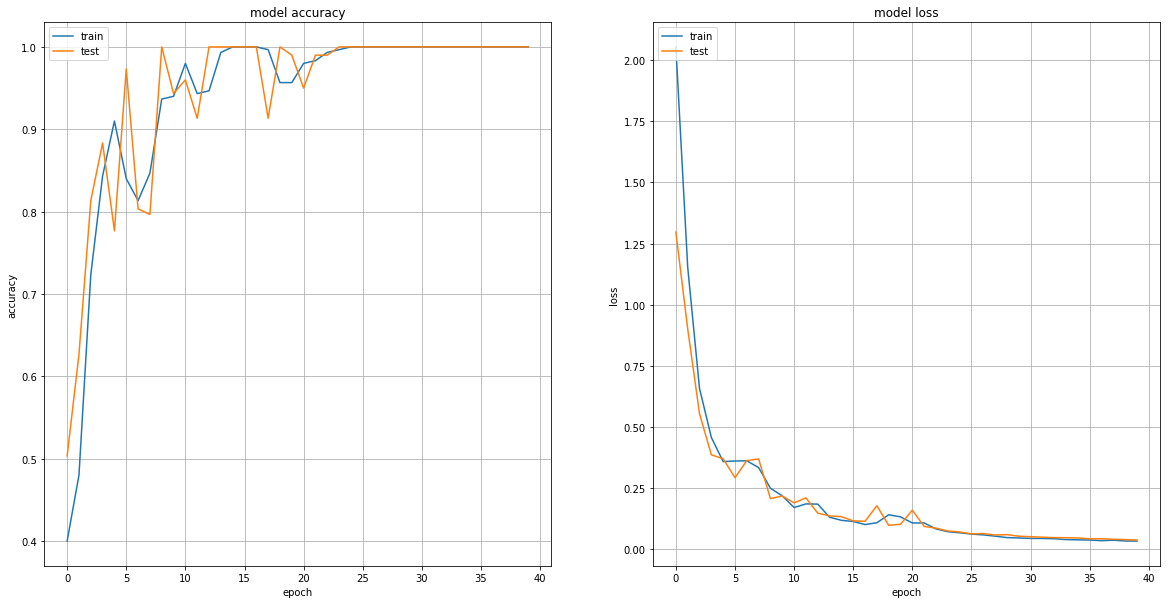

In [10]:
adam = adam_model()
adam.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = adam.fit(X_train, Y_train, batch_size=32, epochs=40, 
                             validation_data=(X_test, Y_test), verbose=0)
plot_history(history)

# 3. Visualization of the Solution

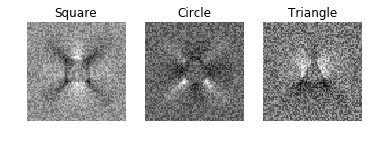

In [11]:
weights = adam.get_weights()[0].reshape(72,72,3)
titles = ["Square", "Circle", "Triangle"]

for k in range(3):
    plt.subplot(1, 3, k + 1)
    plt.imshow(weights[..., k].reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='gray')
    plt.title(titles[k])
    plt.axis("off")

plt.show()

# 4. A More Difficult Classification Problem

In [12]:
X_train, Y_train = generate_dataset_classification(600, 20, True)
X_test, Y_test = generate_test_set_classification(300, 20, True)

Creating data: 100%|██████████| 300/300 [00:02<00:00, 101.08it/s]


300/300 [==============================] - 0s 40us/step
Evaluation on the test set: accuracy 96.00% - loss 0.12


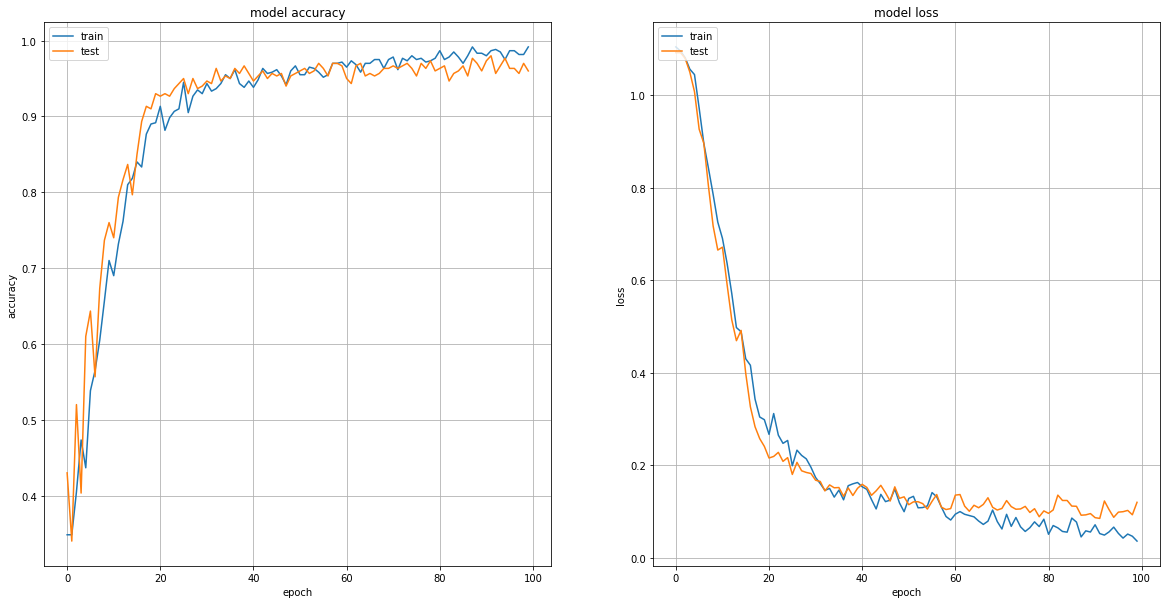

In [16]:
convnet = convnet_model()
convnet.compile(optimizer='adam', loss='categorical_crossentropy', 
                  metrics=['accuracy'])

X_train2 = X_train.reshape(X_train.shape[0], IMAGE_SIZE, IMAGE_SIZE, -1).astype('float32')
X_test2 = X_test.reshape(X_test.shape[0], IMAGE_SIZE, IMAGE_SIZE, -1).astype('float32')

history = convnet.fit(X_train2, Y_train, batch_size=32, epochs=100, 
                             validation_data=(X_test2, Y_test), verbose=0)

evaluation = convnet.evaluate(X_test2, Y_test)
print(f"Evaluation on the test set: accuracy {evaluation[1]*100:.2f}% - loss {evaluation[0]:.2f}")

plot_history(history)



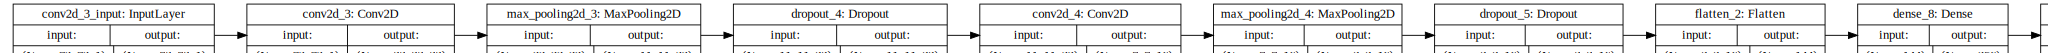

In [21]:
SVG(model_to_dot(convnet, show_shapes=True, rankdir="LR").create(prog='dot', format='svg'))

# 5. Regression problem

In [24]:
n_output = 6
X_train, Y_train = preprocessing(generate_dataset_regression(10000, 20, True))
X_test, Y_test = preprocessing(generate_test_set_regression(300, 20, True)) 

Creating data: 100%|██████████| 300/300 [00:02<00:00, 100.38it/s]


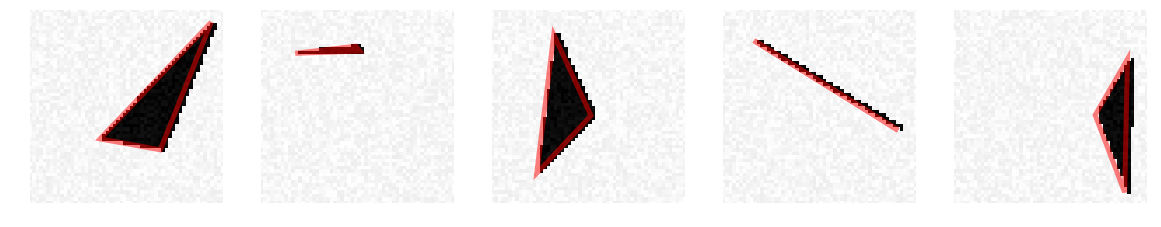

In [26]:
n = 5
visualize_predictions(X_test[:n], Y_test[:n])

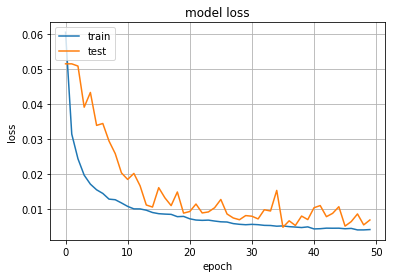

300/300 [==============================] - 0s 234us/step
Evaluation on the test set: MSE 0.01, MAE: 0.05
10000/10000 [==============================] - 1s 95us/step
Evaluation on the train set: MSE 0.00, MAE: 0.04


In [31]:
regressor = regression_model()
regressor.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
progress_bar = TQDMNotebookCallback(show_inner=False)
history = regressor.fit(X_train, Y_train, batch_size=256, epochs=50, shuffle=True, \
                     validation_data = (X_test, Y_test), verbose=0,  callbacks=[progress_bar])
plot_history(history)

evaluation = regressor.evaluate(X_test, Y_test)
print(f"Evaluation on the test set: MSE {evaluation[0]:.2f}, MAE: {evaluation[1]:.2f}")

evaluation = regressor.evaluate(X_train, Y_train)
print(f"Evaluation on the train set: MSE {evaluation[0]:.2f}, MAE: {evaluation[1]:.2f}")

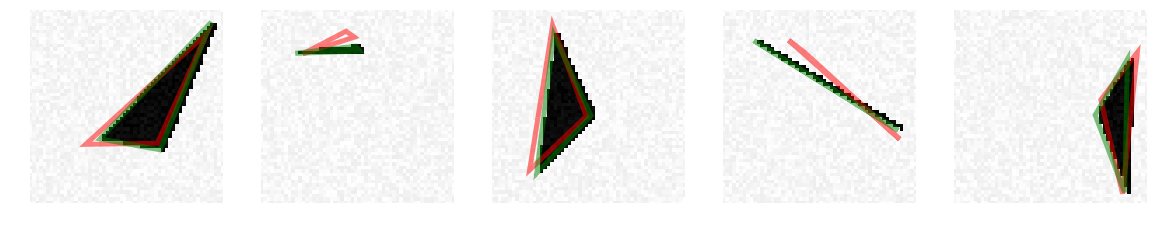

In [33]:
predictions = regressor.predict(X_test)
n = 5
visualize_predictions(X_test[:n], predictions[:n], Y_test[:n])

# 6. Image Denoising
**Implement a hourglass network for denoising: Modifying the generate_a_* functions to generate
pairs of images, where one image has noise with random amplitude, and the second image has the
same content but without the noise. Train your network to predict a noise-free image given a noisy
image as input.**

I did the training with two steps:

- first, I try without activation: it denoises the image but the background is not white;
- secondly, I freeze layers and add a last Dense layer with a sigmoid activation. It denoises the image but also whitens the backgroud!

In [25]:
X_train, Y_train = generate_dataset_noise(10000, 0, True)
X_test, Y_test = generate_dataset_noise(300, 0, True)

noise = 20. / 255.
X_train = Y_train + noise * (2 * np.random.random(Y_train.shape) - 1)
X_train = (X_train + noise) / (1. + 2 * noise)
X_test = Y_test + noise * (2 * np.random.random(Y_test.shape) - 1)
X_test = (X_test + noise) / (1. + 2 * noise)


100%|██████████| 300/300 [00:06<00:00, 45.46it/s]


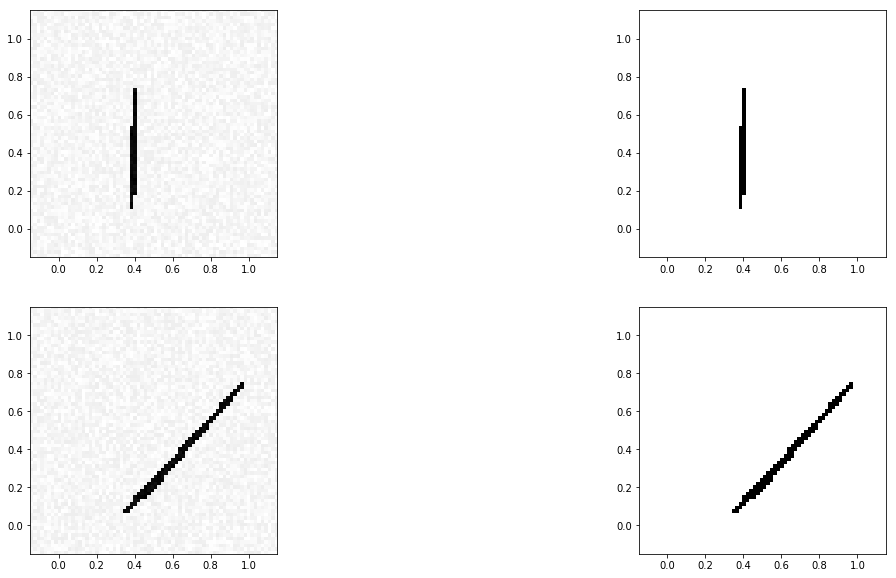

In [37]:
visualize_denoising(X_train[:2], Y_train[:2])

In [27]:
inputs, outputs = autoencoder_model()
model = Model(inputs=inputs, outputs=outputs)
model.compile(loss='mse',
              metrics=['accuracy'],
              optimizer='adadelta')
    
progress_bar = TQDMNotebookCallback(show_inner=True)
mcp = ModelCheckpoint('weights.pretrained_denoising.hdf5', monitor="val_loss",
                    save_best_only=True, save_weights_only=False)
history = model.fit(X_train, Y_train, batch_size=128, epochs=10, shuffle=True, \
                     validation_data=(X_test, Y_test), verbose=0,  
                     callbacks=[progress_bar, mcp])

KeyboardInterrupt: 

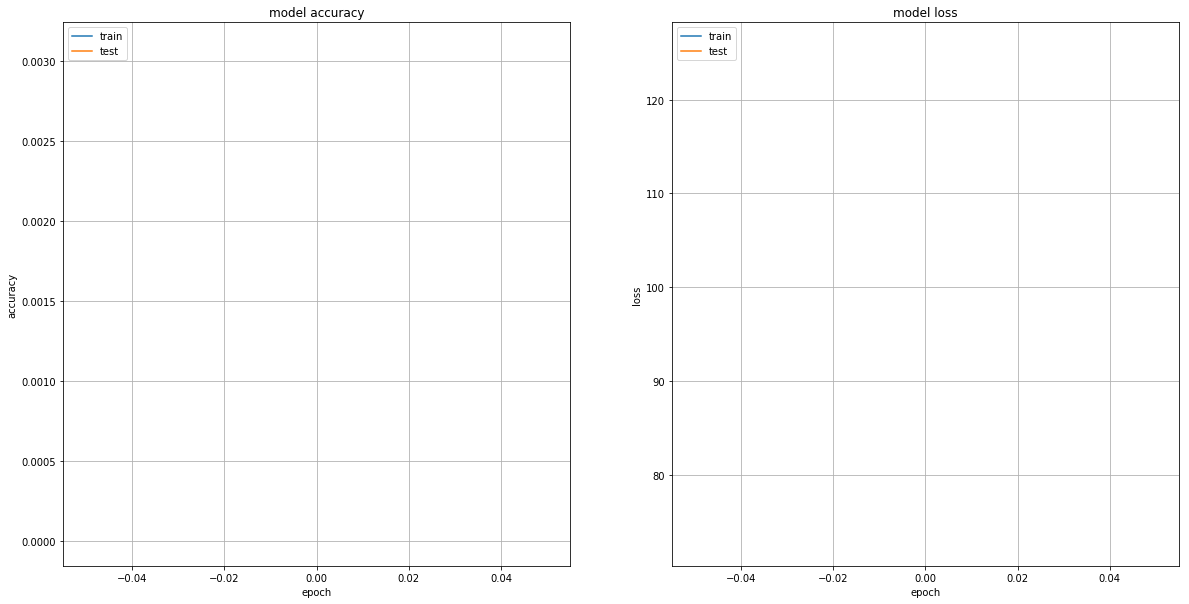

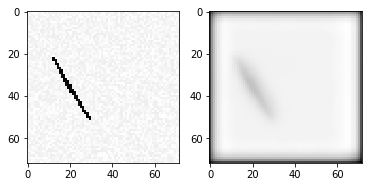

In [43]:
plot_history(history)

plt.subplot(121)
plt.imshow(X_test[0].reshape(72,72), cmap='gray')
plt.subplot(122)
Y_pred = model.predict(X_test[:2])
plt.imshow(Y_pred[0].reshape(72,72), cmap='gray')